In [1]:
"""
From
https://github.com/andykitchen/numpyo-examples/blob/master/sigmoid-changepoint.ipynb
https://www.youtube.com/watch?v=CecuWGpoztw
and slightly streamlined and fixed compatibility
"""

import jax
import jax.numpy as jnp

import numpyro
import numpyro.infer
from numpyro import distributions as dist
from numpyro.infer import MCMC, NUTS
"""
pip3 install arviz
"""
import arviz as az

import numpy
import scipy.special
import scipy.stats

from IPython.display import set_matplotlib_formats

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt



In [8]:


# hard code example coal mining disaster dataset

D = jnp.array([
     4, 5, 4, 0, 1, 4, 3, 4, 0, 6, 3, 3, 4, 0, 2, 6,
     3, 3, 5, 4, 5, 3, 1, 4, 4, 1, 5, 5, 3, 4, 2, 5,
     2, 2, 3, 4, 2, 1, 3, 2, 2, 1, 1, 1, 1, 3, 0, 0,
     1, 0, 1, 1, 0, 0, 3, 1, 0, 3, 2, 2, 0, 1, 1, 1,
     0, 1, 0, 1, 0, 0, 0, 2, 1, 0, 0, 0, 1, 1, 0, 2,
     3, 3, 1, 1, 2, 1, 1, 1, 1, 2, 4, 2, 0, 0, 1, 4,
     0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1],
     dtype=jnp.int32)

N = len(D)
t = jnp.arange(N)                # number of years from the start of the data
t_pres = jnp.arange(1851, 1962)  # real years for presentation in plots



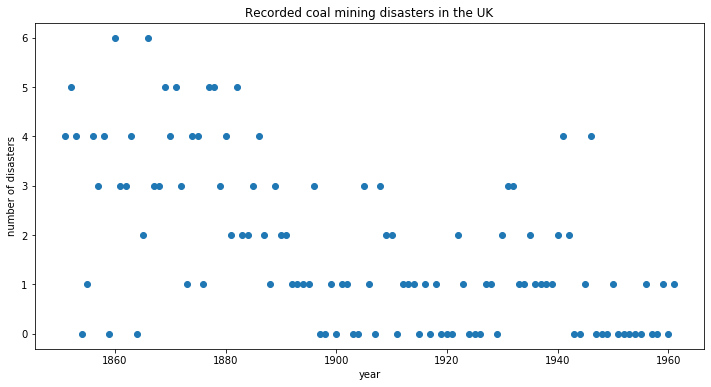

In [9]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.set_title("Recorded coal mining disasters in the UK")
ax.set_ylabel("number of disasters")
ax.set_xlabel("year")
plt.scatter(t_pres, D);

In [14]:


def gen_sigmoid(A, K, B, M, t):
    """
    A generalised sigmoid function

    :param A: starting value (left asymptote)
    :param K: ending value (right asymptote)
    :param B: speed of change (larger values faster change)
    :param M: time of change midpoint (location parameter)
    :param t: input value
    :returns: value of function at t
    """
    return A + ((K - A) / (1. + jnp.exp(-B*(t - M))))



In [48]:


# define the numpyro model function

def continuous_change_point(N, t=None, D=None):
    rate_early  = numpyro.sample('rate_early',  dist.Exponential(1.)) # early disaster rate (disasters / year)
    rate_late   = numpyro.sample('rate_late',   dist.Exponential(1.)) # late disaster rate  (disasters / year)
    rate_scale  = numpyro.sample('rate_scale',  dist.HalfNormal(0.2)) # speed of change     (1 / year)
    #rate_change = numpyro.sample('rate_change', dist.Uniform(0, N))   # change mid-point    (year), can't seem to use with reasonably new numpy :( 
    rate_change = numpyro.sample('rate_change', dist.Normal(0., N))   # change mid-point    (year)
    rate_t      = numpyro.deterministic('rate_t',
                    gen_sigmoid(A=rate_early, K=rate_late, B=rate_scale, M=rate_change, t=t))
                    # compute the disaster rate for each time and save the value
    with numpyro.plate('N', N):
        numpyro.sample('obs', dist.Poisson(rate_t), obs=D) # observe disaster counts from a poisson distribution



In [49]:
nuts_kernel = NUTS(continuous_change_point, adapt_step_size=True)
mcmc = MCMC(nuts_kernel, num_chains=1, num_warmup=1000, num_samples=4000)
rng_key = jax.random.PRNGKey(0)
mcmc.run(rng_key, N, t, D=D )

sample: 100%|██████████| 5000/5000 [00:04<00:00, 1085.83it/s, 3 steps of size 5.97e-01. acc. prob=0.93] 


In [50]:


mcmc.print_summary()




                   mean       std    median      5.0%     95.0%     n_eff     r_hat
  rate_change     37.53      3.30     37.61     32.38     42.99   2489.33      1.00
   rate_early      3.29      0.35      3.27      2.74      3.85   2617.38      1.00
    rate_late      0.88      0.12      0.87      0.68      1.07   3160.88      1.00
   rate_scale      0.26      0.10      0.25      0.09      0.42   2488.21      1.00

Number of divergences: 0


In [52]:


# export samples into ArViz for visualisation
ds = az.from_numpyro(mcmc)



In [38]:
# show the first 50 samples as overlayed transparent lines
n_samples = 50
fig, ax = plt.subplots(figsize=(16, 8))
plt.scatter(t_pres, D)
plt.plot(t_pres, ds.posterior.rate_t[0, :n_samples].T, color='k', alpha=0.1);

In [36]:


t_change = ds.posterior.rate_change + t_pres[0]
float(jnp.mean(jnp.array(t_change)))

1888.52978515625